<a href="https://colab.research.google.com/github/WilliamShengYangHuang/AALU_Workshop_3/blob/main/Image_captioner_with_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title
import os
import torch
from PIL import Image
import pandas as pd
import base64
from io import BytesIO
from transformers import BlipProcessor, BlipForConditionalGeneration
import spacy
from textblob import TextBlob
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load BLIP processor and model
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

# Define image folder path
image_folder = "/content/drive/My Drive/poi_images_around_Trafalgar_Square"  #@param{type:'string'}
output_csv = "/content/drive/My Drive/image_captions.csv"  #@param{type:'string'}

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

### Generate and save captions with sentiment analysis

In [3]:
# @title
# Initialize a list to store image, caption, and sentiment data
data = []

# Iterate over all images in the folder
for filename in os.listdir(image_folder):
    if filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".gif")):
        image_path = os.path.join(image_folder, filename)

        # Open the image
        image = Image.open(image_path).convert("RGB")

        # Generate caption with BLIP
        inputs = processor(image, return_tensors="pt").to(device)
        with torch.no_grad():
            caption_ids = model.generate(**inputs, max_length=30)  # Explicitly set max_length
        caption = processor.decode(caption_ids[0], skip_special_tokens=True)

        # Perform sentiment analysis on the caption using spaCy and TextBlob
        doc = nlp(caption)
        sentiment = TextBlob(doc.text).sentiment.polarity  # Polarity ranges from -1.0 to 1.0

        # Resize the image to a consistent size (optional)
        image = image.resize((512, 512))

        # Convert image to base64 string
        buffered = BytesIO()
        image.save(buffered, format="PNG")
        img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")

        # Append the image, caption, and sentiment to the data list
        data.append({"image": img_str, "caption": caption, "sentiment": sentiment})

# Save the data to a CSV file
df = pd.DataFrame(data)
df.to_csv(output_csv, index=False)

print(f"Images, captions, and sentiments have been saved to {output_csv}")

Images, captions, and sentiments have been saved to /content/drive/My Drive/image_captions.csv


### Read and preview images from the CSV

Loaded 120 entries from /content/drive/My Drive/image_captions.csv


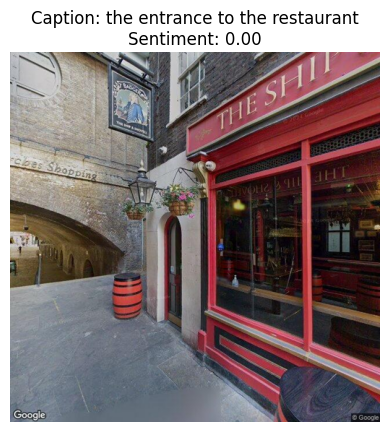

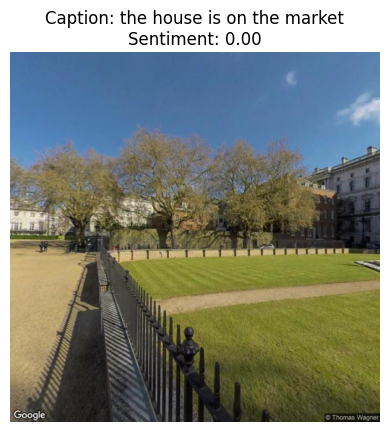

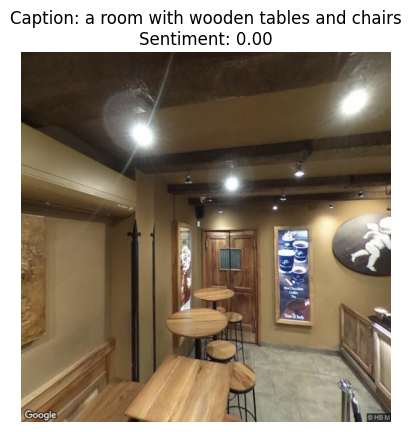

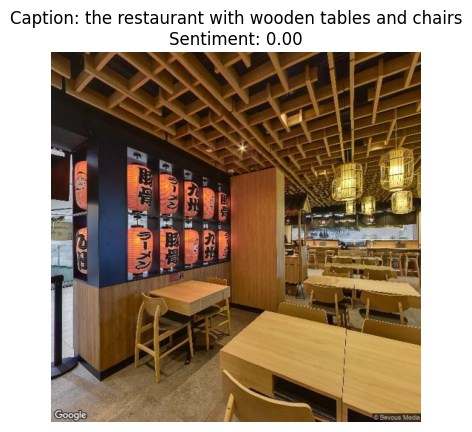

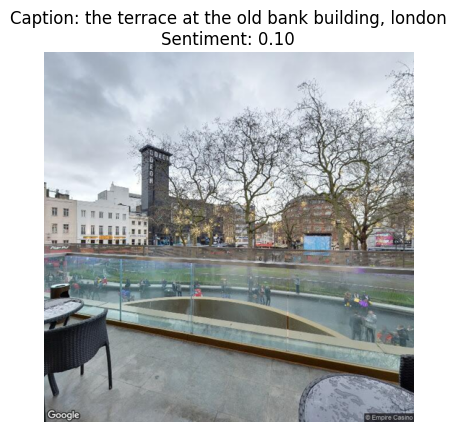

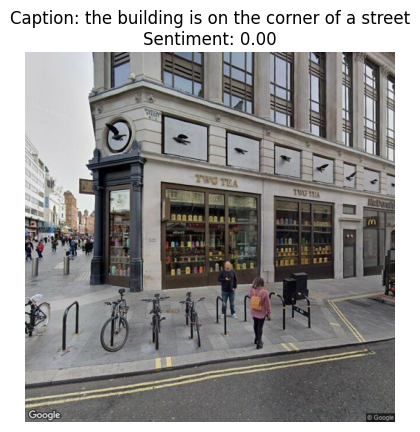

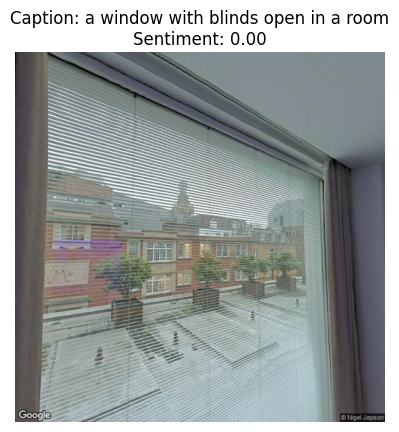

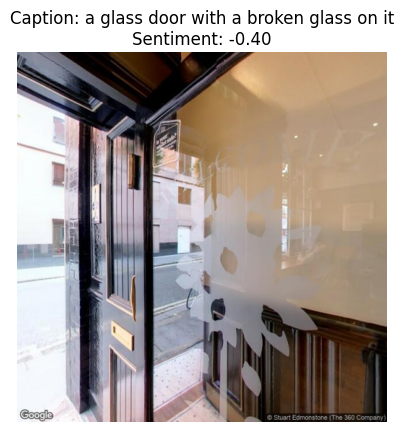

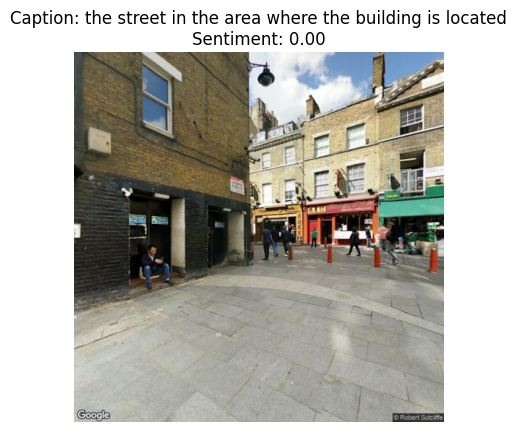

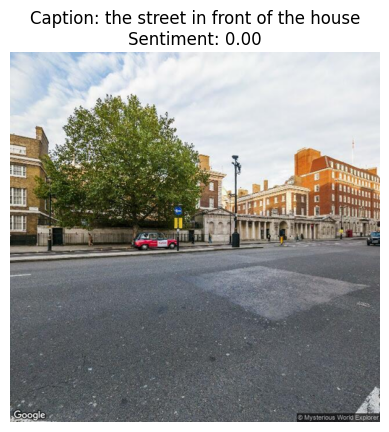

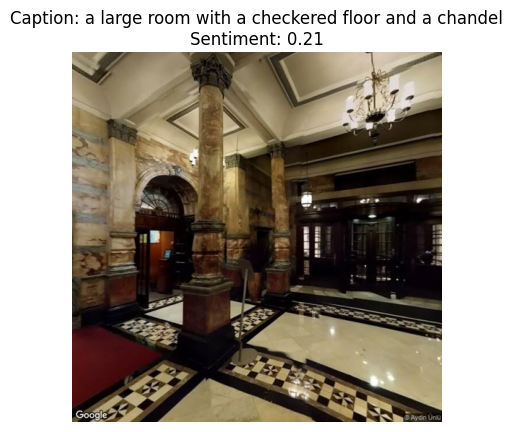

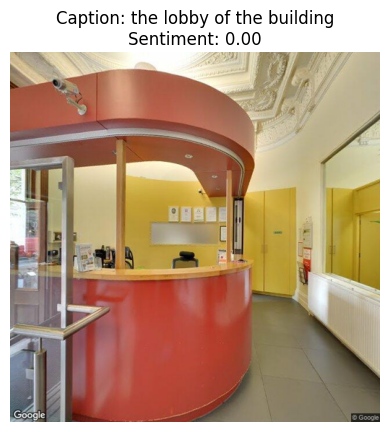

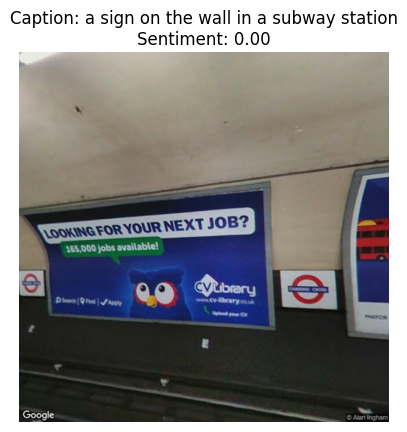

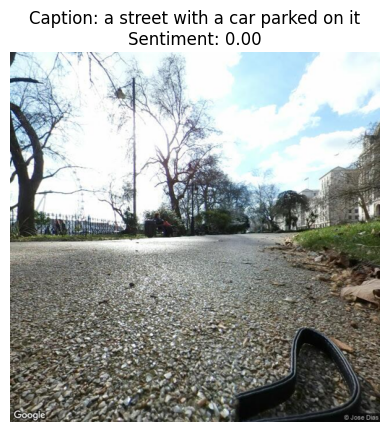

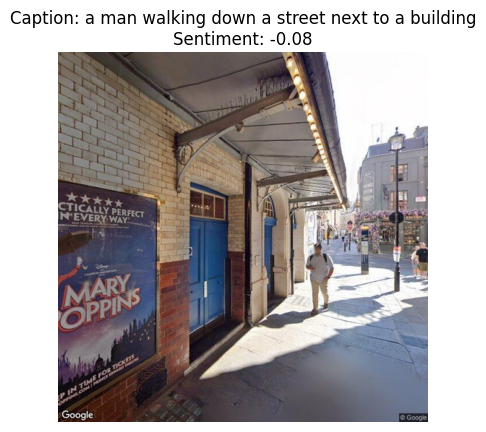

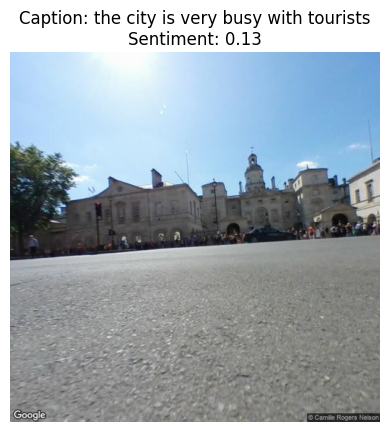

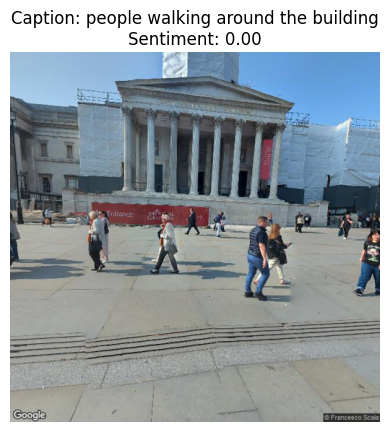

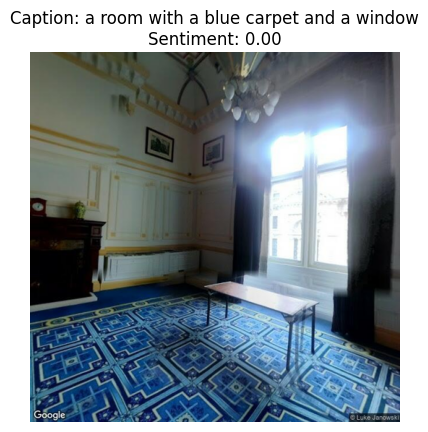

In [ ]:
# @title
def preview_csv(csv_file):
    # Load the CSV
    df = pd.read_csv(csv_file)
    print(f"Loaded {len(df)} entries from {csv_file}")

    # Preview the first 5 images with captions and sentiment
    for idx, row in df.head(-1).iterrows():
        # Decode the base64 image
        img_data = base64.b64decode(row['image'])
        img = Image.open(BytesIO(img_data))

        # Display the image
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Caption: {row['caption']}\nSentiment: {row['sentiment']:.2f}")
        plt.show()

# Run the functions

preview_csv(output_csv)  # Preview images and captions from the CSV